In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#%matplotlib notebook

In [3]:
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_style('white')

from conf import FFTFREQS
from dataset import get_dataset

PLOT = True

mel fiterbank shape = (128, 4097)
STFT time resolution = 32.768 ms
STFT frequency resolution = 15.2587890625 Hz



In [4]:
dataset = get_dataset(recompute=False)

123it [00:00, 979.40it/s]


In [5]:
vocs = np.array([sample['vocalization'] for sample in iter(dataset)])
postnataldays = np.array([sample['postnatalday'].numpy() for sample in iter(dataset)])
nests = np.array([sample['nest'].numpy() for sample in iter(dataset)])
recordings = np.array([sample['recording'].numpy() for sample in iter(dataset)])

dicc_vocs = {
1: 'tab:blue',
2: 'tab:orange'
}
colors_vocs = pd.DataFrame(vocs)[0].map(dicc_vocs)

dicc_recordings = {
b'482': 'y',
b'494': 'g',
b'637': 'r'
} 
colors_recordings = pd.DataFrame(recordings)[0].map(dicc_recordings)

dicc_nests = {
b'1': 'c',
b'2': 'm'
}
colors_nest = pd.DataFrame(nests)[0].map(dicc_nests)

dicc_pnds = dict(zip(set(postnataldays),sns.color_palette("Blues", len(set(postnataldays)))))
colors_pnds = pd.DataFrame(postnataldays)[0].map(dicc_pnds)

colors = pd.concat([colors_vocs, colors_recordings, colors_nest, colors_pnds], axis=1)
colors.columns = ['vocalization', 'recording', 'nest', 'postnatalday']

Text(0.5, 1.0, 'VOCALIZATION TYPE')

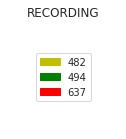

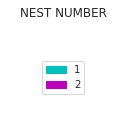

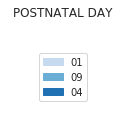

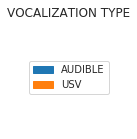

In [6]:
def plot_legend(colordicc, title):
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=l.decode()) for l, c in colordicc.items()]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.legend(handles=legend_elements, loc='center')
    plt.title(title)
    plt.axis('off')

plot_legend(dicc_recordings, 'RECORDING')
plot_legend(dicc_nests, 'NEST NUMBER')
plot_legend(dicc_pnds, 'POSTNATAL DAY')


legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='tab:blue', label='AUDIBLE'),
    Patch(facecolor='tab:orange', edgecolor='tab:orange', label='USV')
]
fig, ax = plt.subplots(figsize=(2, 2))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.title('VOCALIZATION TYPE')

In [7]:
feats = dict()
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    feats[feat] = np.array([sample[feat] for sample in tqdm(iter(dataset))])

123it [00:00, 1323.99it/s]
123it [00:00, 1298.15it/s]
123it [00:00, 1351.56it/s]
123it [00:00, 1370.00it/s]
123it [00:00, 1385.20it/s]
123it [00:00, 1369.71it/s]


In [27]:
xlabels =  np.array([
    sample['recording'].numpy().decode()+'_'+str(sample['sample_nb'].numpy())
    for sample in iter(dataset)
])

dicc_xlabels = dict(zip(set([x[:3] for x in  xlabels]),  sns.xkcd_palette( ["amber", "greyish", "dusty purple"]) ))

In [26]:
ylabels = []

for idx in range(0, len(FFTFREQS), 195):
    ylabels.append(str(int(FFTFREQS[idx])) + ' Hz')

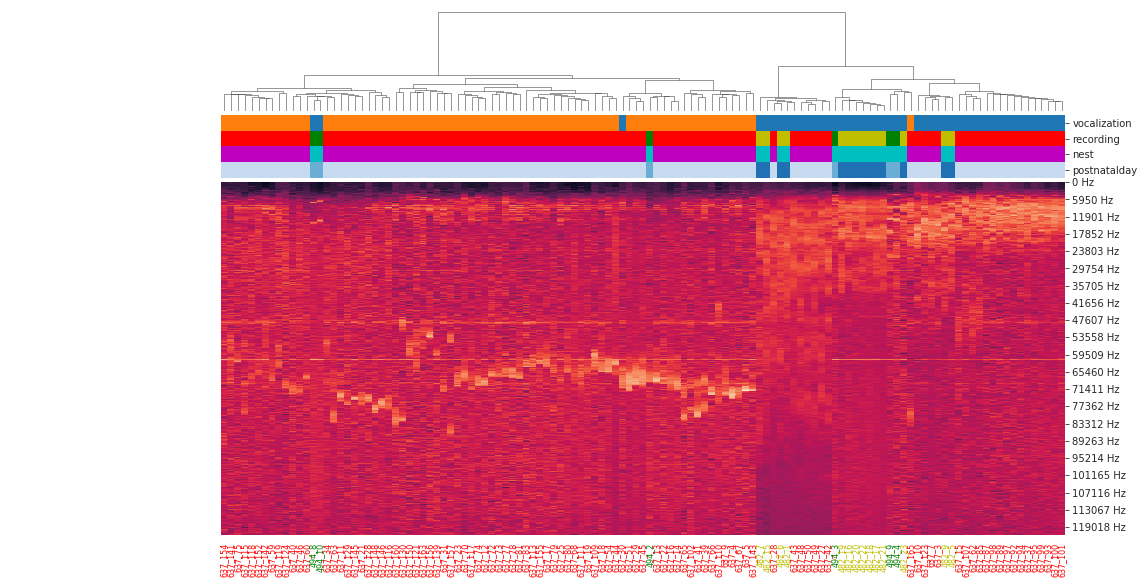

In [58]:
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
AFFINITY = "euclidean"  # "euclidean", "cosine", "sqeuclidean", "cityblock"
LINKAGE = "ward"  #  "ward", "complete", "average", "single"

for feat in ['mean_stft']:  # ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    
    g = sns.clustermap(
        pd.DataFrame(feats[feat].T),
        method=LINKAGE,
        metric=AFFINITY,
        standard_scale=None, # Either 0 (rows) or 1 (columns) or None
        z_score=1, # Either 0 (rows) or 1 (columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels=200)

    
    g.ax_heatmap.axes.set_yticklabels(ylabels)
    
    g.ax_heatmap.axes.set_xticklabels([
       xlabels[int(x.get_text())]  for x in g.ax_heatmap.axes.get_xticklabels()
    ])
    
    for tick in g.ax_heatmap.axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
        tick.label.set_rotation('vertical')
        
             
    for tick_label in g.ax_heatmap.axes.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(dicc_recordings[tick_text[:3].encode()])
    

    if feat[-4:] == 'stft':
        for tick in g.ax_heatmap.axes.yaxis.get_major_ticks():
            tick.label.set_fontsize(2) 
            tick.label.set_rotation('horizontal')
        
     